# 2kr Analysis

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product, chain, combinations
from scipy import stats
from IPython.display import display, HTML
%matplotlib inline

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

def get_file_name(name):
    return name.replace(':', '-')

## Config

In [2]:
inputFile = 'data.csv'
repetitionsCount = -1 # -1 = auto-detect
factors = ['R', 'T', 'm', 'D']

tIntervalAlpha = 0.95

plotSize = (10, 10)
plotStyle = 'seaborn-whitegrid'
saveFigures = False

# Filter scalars
scalarsFilter = ['Floorplan.userCount', 'Floorplan.coveredUsers:sum', 'Floorplan.collisions:sum', 'Floorplan.msgsPerSlot:sum']
# Filter vectors
vectorsFilter = ['Floorplan.coveredUsers:vector']
# Percentiles
percentiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

# Performance indexes
perfIndexes = [
    ('coveredUsersPercent', 'percentage of covered users'),
    ('Floorplan.collisions:sum', 'total number of collisions'),
    ('Floorplan.msgsPerSlot:sum', 'total number of messages sent'),
]

# Transformations
transformations = [
]

intPercentiles = [int(i*100) for i in percentiles]
vecPerfIndexes = []
for intPercentile in intPercentiles:
    vecPerfIndexes.append(('broadcastTime' + str(intPercentile), 'Broadcast time needed to reach the ' + str(intPercentile) + 'th percentile of the coverage'))
for v in vecPerfIndexes:
    perfIndexes.append(v)
    transformations.append((v[0], lambda x: math.log(x)))

## Load scalars

In [3]:
df = pd.read_csv('exported_data/' + inputFile, converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray,
})

In [4]:
if repetitionsCount <= 0: # auto-detect
    repetitionsCount = int(df[df.attrname == 'repetition']['attrvalue'].max()) + 1
print('Repetitions:', repetitionsCount)

# Computed
factorsCount = len(factors)
configsCount = 2**factorsCount
totalSims = configsCount*repetitionsCount

combinedFactors = list(chain(*[list(map(''.join, combinations(''.join(factors), i))) for i in range(1, factorsCount+1)]))
freedomDegrees = configsCount*(repetitionsCount - 1)


display(HTML("<style>div.output_scroll { height: auto; max-height: 48em; }</style>"))
pd.set_option('display.max_rows', totalSims)
pd.set_option('display.max_columns', 2*configsCount*repetitionsCount+1)
if saveFigures:
    os.makedirs('figures', exist_ok=True)

Repetitions: 10


In [5]:
scalars = df[(df.type == 'scalar') | ((df.type == 'itervar') & (df.attrname != 'TO')) | ((df.type == 'param') & (df.attrname == 'Floorplan.userCount')) | ((df.type == 'runattr') & (df.attrname == 'repetition'))]
scalars = scalars.assign(qname = scalars.attrname.combine_first(scalars.module + '.' + scalars.name))
for index, row in scalars[scalars.type == 'itervar'].iterrows():
    val = scalars.loc[index, 'attrvalue']
    if isinstance(val, str)  and not all(c.isdigit() for c in val):
        scalars.loc[index, 'attrvalue'] = eval(val)
scalars.value = scalars.value.combine_first(scalars.attrvalue.astype('float64'))
scalars_wide = scalars.pivot_table(index=['run'], columns='qname', values='value')
scalars_wide.sort_values([*factors, 'repetition'], inplace=True)
count = 0
for index in scalars_wide.index:
    config = count // repetitionsCount
    scalars_wide.loc[index, 'config'] = config
    count += 1
scalars_wide = scalars_wide[['config', 'repetition', *factors, *scalarsFilter]]

# coverage
scalars_wide['coveredUsersPercent'] = scalars_wide['Floorplan.coveredUsers:sum'] / (scalars_wide['Floorplan.userCount'] - 1)

## Load vectors

In [6]:
vectors = df[df.type == 'vector']
vectors = vectors.assign(qname = vectors.module + '.' + vectors.name)
for index in scalars_wide.index:
    r = index
    cfg = scalars_wide.loc[index, 'config']
    rep = scalars_wide.loc[index, 'repetition']
    vectors.loc[vectors.run == r, 'config'] = cfg
    vectors.loc[vectors.run == r, 'repetition'] = rep
vectors = vectors[vectors.qname.isin(vectorsFilter)]
vectors.sort_values(['config', 'repetition', 'qname'], inplace=True)
vectors = vectors[['config', 'repetition', 'qname', 'vectime', 'vecvalue']]

## Compute scalars from vectors

In [7]:
def get_percentile(percentile, vectime, vecvalue, totalvalue):
    tofind = percentile * totalvalue
    idx = 0
    csum = vecvalue.cumsum()
    for value in csum:
        if value >= tofind:
            return vectime[idx]
        idx += 1
    return math.inf

for index, row in vectors.iterrows():
    for vecPerf, percentile in zip(vecPerfIndexes, percentiles):
        vecPerfIndex = vecPerf[0]
        cfg = row['config']
        rep = row['repetition']
        if vecPerfIndex.startswith('broadcastTime'):
            total = scalars_wide[(scalars_wide['config'] == cfg) & (scalars_wide['repetition'] == rep)]['Floorplan.userCount'].values[0] - 1
        else:
            raise Exception('Need to specify total for ' + vecPerfIndex + '. (coding required)')
        value = get_percentile(percentile, row['vectime'], row['vecvalue'], total)
        scalars_wide.loc[(scalars_wide['config'] == cfg) & (scalars_wide['repetition'] == rep), vecPerfIndex] = value

## Apply transformations

In [8]:
for col, transform in transformations:
    scalars_wide[col] = scalars_wide[col].map(transform, 'ignore')

## 2kr

In [9]:
cols = ['exp', 'I'] + combinedFactors
data = [[e, 1] + list(chain(*[list(map(np.prod, combinations(r, i))) for i in range(1, len(r)+1)])) for r,e in zip([list(x) for x in product([-1, 1], repeat=factorsCount)], range(0, configsCount))]
factorsMatrix = pd.DataFrame.from_records(data, columns=cols, index='exp')

computeMatrices = []
ciMatrices = []
errorVariances = []
skipped = []

for perfIndex, perfIndexDesc in perfIndexes:
    print("2^k*r analysis for the", perfIndexDesc)
    cols = ['exp'] + ['y' + str(i) for i in range(0, repetitionsCount)]
    data = [[i] + scalars_wide[scalars_wide.config == i][perfIndex].values.tolist() for i in range(0, configsCount)]
    ysMatrix = pd.DataFrame.from_records(data, columns=cols, index='exp')
    ysMatrix['mean'] = ysMatrix.mean(axis=1)
    next2kr = False
    for r in range(0, repetitionsCount):
        for c in range(0, configsCount):
            if math.isinf(ysMatrix['y' + str(r)].values[c]):
                print('!!! Observations contain infinite values. Skipping...')
                print()
                skipped.append(perfIndex)
                next2kr = True
                break
        if next2kr:
            break
        ysMatrix['e' + str(r)] = ysMatrix['y' + str(r)] - ysMatrix['mean']
    if next2kr:
        continue

    matrix = pd.concat([factorsMatrix, ysMatrix], axis=1)

    computeCols = ['idx', 'I'] + combinedFactors + ['e' + str(r) for r in range(0, repetitionsCount)]
    data = [['Sum'], ['Mean (Qi)'], ['SSQ']]
    SSE = 0
    for col in computeCols[1:]:
        sumvalue = np.sum(matrix[col].values * matrix['mean'].values)
        data[0].append(sumvalue)
        data[1].append(sumvalue / configsCount)
        if col in ['e' + str(r) for r in range(0, repetitionsCount)]:
            ssq = np.sum(matrix[col].values * matrix[col].values)
            data[2].append(ssq)
            SSE += ssq
        else:
            data[2].append('')
    computeMatrix = pd.DataFrame.from_records(data, columns=computeCols, index='idx')

    data = [['(2^k)*r*(qi)^2'], ['Variation'], ['Variation%']]
    SST = SSE
    for col in combinedFactors:
        qi = computeMatrix.loc['Mean (Qi)', col]
        r2kqi2 = configsCount*repetitionsCount*(qi**2)
        data[0].append(r2kqi2)
        SST += r2kqi2
    data[0].append(SSE)
    idx = 1
    for col in combinedFactors:
        r2kqi2 = data[0][idx]
        var = r2kqi2 / SST
        data[1].append(var)
        data[2].append('{:.2%}'.format(var))
        idx += 1
    data[1].append(SST)
    data[2].append('{:.2%}'.format(SSE/SST))
    resultMatrix = pd.DataFrame.from_records(data, columns=['idx'] + combinedFactors + ['SSE/SST'], index='idx')

    errorVariance = SSE / freedomDegrees
    negativeInterval, positiveInterval = tuple(v*math.sqrt(errorVariance/(configsCount*repetitionsCount)) for v in stats.t.interval(tIntervalAlpha, freedomDegrees))
    data = [['CI+ Qi ({:.2%})'.format(tIntervalAlpha)], ['CI- Qi ({:.2%})'.format(tIntervalAlpha)], ['Distance (Qi)'], ['Zero Included'], ['CI+ Variation'], ['CI- Variation'], ['CI Distance (Variation)']]
    for col in combinedFactors:
        qi = computeMatrix.loc['Mean (Qi)', col]
        upper = qi + positiveInterval
        lower = qi + negativeInterval
        data[0].append(upper)
        data[1].append(lower)
        data[2].append(abs(upper - lower))
        data[3].append(upper >= 0 and lower <= 0)
        upper = (configsCount*repetitionsCount*(upper**2))/SST
        lower = (configsCount*repetitionsCount*(lower**2))/SST
        data[4].append(upper)
        data[5].append(lower)
        data[6].append(abs(upper - lower))
    ciMatrix = pd.DataFrame.from_records(data, columns=['idx'] + combinedFactors, index='idx')

    computeMatrices.append(computeMatrix)
    ciMatrices.append(ciMatrix)
    errorVariances.append(errorVariance)

    display(matrix)
    display(computeMatrix)
    display(resultMatrix)
    display(ciMatrix)

    print('SSE =', SSE)
    print('SST =', SST)
    print('Error variance =', errorVariance)
    print('Unexplained Variation =', '{:.2%}'.format(SSE/SST))
    print()
    print('####################################')
    print()

2^k*r analysis for the percentage of covered users


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,0.998666,0.998666,1.000000,0.997332,0.999333,1.000000,0.996664,0.997332,1.000000,0.999333,0.998732,-0.000067,-0.000067,0.001268,-0.001401,0.000600,0.001268,-0.002068,-0.001401,0.001268,0.000600
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,0.999333,1.000000,1.000000,1.000000,0.999333,0.999333,0.999333,0.999333,0.999333,1.000000,0.999600,-0.000267,0.000400,0.000400,0.000400,-0.000267,-0.000267,-0.000267,-0.000267,-0.000267,0.000400
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,1.000000,1.000000,0.999333,0.999333,1.000000,1.000000,1.000000,1.000000,0.999333,0.997999,0.999600,0.000400,0.000400,-0.000267,-0.000267,0.000400,0.000400,0.000400,0.000400,-0.000267,-0.001601
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,1.000000,1.000000,0.999333,1.000000,1.000000,1.000000,1.000000,0.999333,1.000000,1.000000,0.999867,0.000133,0.000133,-0.000534,0.000133,0.000133,0.000133,0.000133,-0.000534,0.000133,0.000133
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,1.000000,1.000000,0.993996,1.000000,1.000000,0.997999,1.000000,0.999333,0.999333,1.000000,0.999066,0.000934,0.000934,-0.005070,0.000934,0.000934,-0.001067,0.000934,0.000267,0.000267,0.000934
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,0.999333,1.000000,1.000000,0.995330,1.000000,0.999333,1.000000,1.000000,0.998666,0.998666,0.999133,0.000200,0.000867,0.000867,-0.003803,0.000867,0.000200,0.000867,0.000867,-0.000467,-0.000467
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,1.000000,1.000000,0.999333,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999933,0.000067,0.000067,-0.000600,0.000067,0.000067,0.000067,0.000067,0.000067,0.000067,0.000067
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,0.999333,1.000000,1.000000,0.999333,1.000000,1.000000,1.000000,1.000000,1.000000,0.997999,0.999666,-0.000334,0.000334,0.000334,-0.000334,0.000334,0.000334,0.000334,0.000334,0.000334,-0.001668


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,15.993596,0.001734,0.000534,0.003069,0.002535,-0.000133,-0.002668,-0.0,0.002001,-0.000667,-0.001334,0.000801,0.001334,-0.000133,0.000267,-0.000934,0.002400,0.005067,-0.004934,-0.002265,0.003733,0.003067,0.002401,-0.002933,0.001733,-0.008268
Mean (Qi),0.9996,0.000108,0.000033,0.000192,0.000158,-0.000008,-0.000167,-0.0,0.000125,-0.000042,-0.000083,0.00005,0.000083,-0.000008,0.000017,-0.000058,0.000150,0.000317,-0.000308,-0.000142,0.000233,0.000192,0.000150,-0.000183,0.000108,-0.000517
SSQ,,,,,,,,,,,,,,,,,0.000002,0.000003,0.000032,0.000019,0.000003,0.000004,0.000007,0.000013,0.000002,0.000037


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,0.000002,0.0,0.000006,0.000004,0.0,0.000004,0.0,0.000003,0.0,0.000001,0.0,0.000001,0.0,0.0,0.000001,0.000123
Variation,0.012944,0.001225,0.040518,0.02765,0.000077,0.030637,0.0,0.017233,0.001915,0.007659,0.002757,0.007659,0.000077,0.000306,0.003753,0.000145
Variation%,1.29%,0.12%,4.05%,2.77%,0.01%,3.06%,0.00%,1.72%,0.19%,0.77%,0.28%,0.77%,0.01%,0.03%,0.38%,84.56%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),0.000253,0.000178,0.000336,0.000303,0.000136,-0.000022,0.000144,0.000269,0.000103,0.000061,0.000194,0.000228,0.000136,0.000161,0.000086
CI- Qi (95.00%),-0.000036,-0.000111,0.000047,0.000014,-0.000153,-0.000311,-0.000144,-0.000019,-0.000186,-0.000228,-0.000094,-0.000061,-0.000153,-0.000128,-0.000203
Distance (Qi),0.000289,0.000289,0.000289,0.000289,0.000289,0.000289,0.000289,0.000289,0.000289,0.000289,0.000289,0.000289,0.000289,0.000289,0.000289
Zero Included,True,True,False,False,True,False,True,True,True,True,True,True,True,True,True
CI+ Variation,0.070351,0.034772,0.124436,0.100964,0.020367,0.000556,0.022942,0.079942,0.011601,0.004089,0.041606,0.057113,0.020367,0.02855,0.008136
CI- Variation,0.001421,0.013562,0.002483,0.00022,0.025669,0.106602,0.022942,0.000408,0.038112,0.057113,0.009792,0.004089,0.025669,0.017946,0.045253
CI Distance (Variation),0.06893,0.021209,0.121954,0.100744,0.005302,0.106047,0.0,0.079535,0.026512,0.053023,0.031814,0.053023,0.005302,0.010605,0.037116


SSE = 0.00012283038592328052
SST = 0.00014526028248318027
Error variance = 8.529887911338924e-07
Unexplained Variation = 84.56%

####################################

2^k*r analysis for the total number of collisions


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,846.0,847.0,811.0,851.0,839.0,915.0,726.0,733.0,914.0,942.0,842.4,3.6,4.6,-31.4,8.6,-3.4,72.6,-116.4,-109.4,71.6,99.6
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,522.0,528.0,568.0,485.0,530.0,567.0,557.0,547.0,538.0,516.0,535.8,-13.8,-7.8,32.2,-50.8,-5.8,31.2,21.2,11.2,2.2,-19.8
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,1337.0,1359.0,1386.0,1430.0,1354.0,1350.0,1238.0,1285.0,1385.0,1388.0,1351.2,-14.2,7.8,34.8,78.8,2.8,-1.2,-113.2,-66.2,33.8,36.8
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,745.0,881.0,739.0,727.0,815.0,762.0,747.0,735.0,720.0,742.0,761.3,-16.3,119.7,-22.3,-34.3,53.7,0.7,-14.3,-26.3,-41.3,-19.3
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,841.0,797.0,775.0,732.0,686.0,768.0,760.0,745.0,689.0,755.0,754.8,86.2,42.2,20.2,-22.8,-68.8,13.2,5.2,-9.8,-65.8,0.2
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,476.0,471.0,519.0,491.0,550.0,388.0,492.0,395.0,430.0,586.0,479.8,-3.8,-8.8,39.2,11.2,70.2,-91.8,12.2,-84.8,-49.8,106.2
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,1267.0,1350.0,1353.0,1222.0,1394.0,1329.0,1224.0,1265.0,1268.0,1242.0,1291.4,-24.4,58.6,61.6,-69.4,102.6,37.6,-67.4,-26.4,-23.4,-49.4
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,840.0,907.0,877.0,969.0,847.0,911.0,859.0,941.0,905.0,888.0,894.4,-54.4,12.6,-17.4,74.6,-47.4,16.6,-35.4,46.6,10.6,-6.4
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,3399.0,4329.0,3576.0,2955.0,4494.0,3691.0,4057.0,3895.0,4098.0,3252.0,3774.6,-375.6,554.4,-198.6,-819.6,719.4,-83.6,282.4,120.4,323.4,-522.6


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,41927.4,28105.2,803.8,14225.6,-7728.2,944.4,10854.6,-4591.2,3396.4,1150.2,-1917.6,2962.6,701.2,-1107.0,319.2,-3.4,3.212968e+06,-741946.160,1.957070e+06,-2.100600e+06,3.472944e+06,2.107715e+06,-5.336640e+06,380389.44,-335512.06000,-2.616387e+06
Mean (Qi),2620.4625,1756.575,50.2375,889.1,-483.0125,59.025,678.4125,-286.95,212.275,71.8875,-119.85,185.1625,43.825,-69.1875,19.95,-0.2125,2.008105e+05,-46371.635,1.223169e+05,-1.312875e+05,2.170590e+05,1.317322e+05,-3.335400e+05,23774.34,-20969.50375,-1.635242e+05
SSQ,,,,,,,,,,,,,,,,,4.760616e+05,674673.760,3.935882e+05,9.896802e+05,9.089380e+05,2.626736e+05,6.426734e+05,206723.56,375307.56000,5.682948e+05


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,493688916.9,403809.025,126479809.6,37328172.025,557432.1,73638963.225,13174448.4,7209708.1,826850.025,2298243.6,5485624.225,307300.9,765905.625,63680.4,7.225,5498614.4
Variation,0.643052,0.000526,0.164746,0.048622,0.000726,0.095918,0.01716,0.009391,0.001077,0.002994,0.007145,0.0004,0.000998,0.000083,0.0,767727485.775
Variation%,64.31%,0.05%,16.47%,4.86%,0.07%,9.59%,1.72%,0.94%,0.11%,0.30%,0.71%,0.04%,0.10%,0.01%,0.00%,0.72%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),1787.110055,80.772555,919.635055,-452.477445,89.560055,708.947555,-256.414945,242.810055,102.422555,-89.314945,215.697555,74.360055,-38.652445,50.485055,30.322555
CI- Qi (95.00%),1726.039945,19.702445,858.564945,-513.547555,28.489945,647.877445,-317.485055,181.739945,41.352445,-150.385055,154.627445,13.289945,-99.722555,-10.585055,-30.747555
Distance (Qi),61.07011,61.07011,61.07011,61.07011,61.07011,61.07011,61.07011,61.07011,61.07011,61.07011,61.07011,61.07011,61.07011,61.07011,61.07011
Zero Included,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True
CI+ Variation,0.665603,0.00136,0.176256,0.042668,0.001672,0.104747,0.013702,0.012287,0.002186,0.001662,0.009696,0.001152,0.000311,0.000531,0.000192
CI- Variation,0.62089,0.000081,0.153624,0.054963,0.000169,0.087478,0.021007,0.006884,0.000356,0.004713,0.004983,0.000037,0.002073,0.000023,0.000197
CI Distance (Variation),0.044713,0.001279,0.022632,0.012295,0.001502,0.017269,0.007304,0.005403,0.00183,0.003051,0.004713,0.001116,0.001761,0.000508,0.000005


SSE = 5498614.4
SST = 767727485.775
Error variance = 38184.822222222225
Unexplained Variation = 0.72%

####################################

2^k*r analysis for the total number of messages sent


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,1040.0,1035.0,1027.0,1018.0,1017.0,1054.0,981.0,999.0,1043.0,1042.0,1025.6,14.4,9.4,1.4,-7.6,-8.6,28.4,-44.6,-26.6,17.4,16.4
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,1094.0,1093.0,1086.0,1080.0,1129.0,1076.0,1099.0,1088.0,1081.0,1095.0,1092.1,1.9,0.9,-6.1,-12.1,36.9,-16.1,6.9,-4.1,-11.1,2.9
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,1500.0,1500.0,1499.0,1499.0,1500.0,1500.0,1500.0,1500.0,1499.0,1497.0,1499.4,0.6,0.6,-0.4,-0.4,0.6,0.6,0.6,0.6,-0.4,-2.4
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,1500.0,1500.0,1499.0,1500.0,1500.0,1500.0,1500.0,1499.0,1500.0,1500.0,1499.8,0.2,0.2,-0.8,0.2,0.2,0.2,0.2,-0.8,0.2,0.2
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,958.0,982.0,983.0,956.0,928.0,948.0,950.0,975.0,927.0,981.0,958.8,-0.8,23.2,24.2,-2.8,-30.8,-10.8,-8.8,16.2,-31.8,22.2
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,916.0,926.0,920.0,896.0,906.0,877.0,900.0,892.0,897.0,961.0,909.1,6.9,16.9,10.9,-13.1,-3.1,-32.1,-9.1,-17.1,-12.1,51.9
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,1487.0,1488.0,1487.0,1481.0,1494.0,1483.0,1495.0,1477.0,1483.0,1490.0,1486.5,0.5,1.5,0.5,-5.5,7.5,-3.5,8.5,-9.5,-3.5,3.5
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,1475.0,1480.0,1481.0,1477.0,1490.0,1484.0,1487.0,1488.0,1471.0,1480.0,1481.3,-6.3,-1.3,-0.3,-4.3,8.7,2.7,5.7,6.7,-10.3,-1.3
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,831.0,929.0,822.0,737.0,894.0,842.0,876.0,834.0,907.0,771.0,844.3,-13.3,84.7,-22.3,-107.3,49.7,-2.3,31.7,-10.3,62.7,-73.3


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,18617.5,-1287.7,-932.1,5024.1,-186.1,-369.7,1061.3,-210.1,582.5,-261.7,88.5,145.7,-18.1,131.7,161.7,-59.5,-4059.530000,64629.170000,47204.870000,-134056.730000,103436.670000,3455.470000,-63014.030000,-23329.630000,-3331.330000,9065.070000
Mean (Qi),1163.59375,-80.48125,-58.25625,314.00625,-11.63125,-23.10625,66.33125,-13.13125,36.40625,-16.35625,5.53125,9.10625,-1.13125,8.23125,10.10625,-3.71875,-253.720625,4039.323125,2950.304375,-8378.545625,6464.791875,215.966875,-3938.376875,-1458.101875,-208.208125,566.566875
SSQ,,,,,,,,,,,,,,,,,682.730000,12900.330000,4600.930000,17268.130000,7509.330000,3722.730000,10239.730000,6422.930000,6756.330000,16392.530000


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,1036357.05625,543006.50625,15775988.00625,21645.75625,85423.80625,703973.55625,27588.75625,212066.40625,42804.30625,4895.15625,13267.80625,204.75625,10840.55625,16341.80625,2212.65625,86495.7
Variation,0.055769,0.02922,0.848942,0.001165,0.004597,0.037882,0.001485,0.011412,0.002303,0.000263,0.000714,0.000011,0.000583,0.000879,0.000119,18583112.59375
Variation%,5.58%,2.92%,84.89%,0.12%,0.46%,3.79%,0.15%,1.14%,0.23%,0.03%,0.07%,0.00%,0.06%,0.09%,0.01%,0.47%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-76.65151,-54.42651,317.83599,-7.80151,-19.27651,70.16099,-9.30151,40.23599,-12.52651,9.36099,12.93599,2.69849,12.06099,13.93599,0.11099
CI- Qi (95.00%),-84.31099,-62.08599,310.17651,-15.46099,-26.93599,62.50151,-16.96099,32.57651,-20.18599,1.70151,5.27651,-4.96099,4.40151,6.27651,-7.54849
Distance (Qi),7.659481,7.659481,7.659481,7.659481,7.659481,7.659481,7.659481,7.659481,7.659481,7.659481,7.659481,7.659481,7.659481,7.659481,7.659481
Zero Included,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True
CI+ Variation,0.050587,0.025505,0.869777,0.000524,0.003199,0.042383,0.000745,0.013939,0.001351,0.000754,0.001441,0.000063,0.001252,0.001672,0.0
CI- Variation,0.061203,0.033189,0.82836,0.002058,0.006247,0.033634,0.002477,0.009137,0.003508,0.000025,0.00024,0.000212,0.000167,0.000339,0.000491
CI Distance (Variation),0.010615,0.007684,0.041416,0.001534,0.003048,0.008749,0.001732,0.004802,0.002157,0.00073,0.001201,0.000149,0.001086,0.001333,0.00049


SSE = 86495.7
SST = 18583112.593749996
Error variance = 600.6645833333333
Unexplained Variation = 0.47%

####################################

2^k*r analysis for the Broadcast time needed to reach the 25th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,4.276666,3.737670,4.204693,3.828641,3.828641,4.043051,4.007333,4.043051,3.806662,4.007333,3.978374,0.298292,-0.240705,0.226318,-0.149733,-0.149733,0.064677,0.028959,0.064677,-0.171712,0.028959
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,4.174387,3.970292,4.248495,4.430817,4.094345,3.828641,4.025352,4.189655,3.891820,3.988984,4.084279,0.090108,-0.113987,0.164216,0.346538,0.010066,-0.255637,-0.058927,0.105376,-0.192458,-0.095295
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,3.951244,3.737670,3.806662,4.234107,3.784190,4.043051,4.174387,3.871201,4.094345,3.891820,3.958868,-0.007624,-0.221198,-0.152205,0.275239,-0.174678,0.084184,0.215520,-0.087667,0.135477,-0.067047
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,3.951244,4.007333,3.988984,3.951244,4.094345,4.043051,4.143135,3.970292,3.970292,4.356709,4.047663,-0.096419,-0.040330,-0.058679,-0.096419,0.046682,-0.004612,0.095472,-0.077371,-0.077371,0.309046
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,4.584967,4.317488,4.532599,4.394449,4.976734,4.406719,4.521789,4.804021,4.330733,4.762174,4.563167,0.021800,-0.245679,-0.030568,-0.168718,0.413566,-0.156448,-0.041379,0.240854,-0.232434,0.199007
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,4.574711,4.543295,4.955827,4.787492,4.787492,4.488636,4.663439,4.553877,4.564348,4.553877,4.647299,-0.072588,-0.104005,0.308528,0.140192,0.140192,-0.158663,0.016140,-0.093422,-0.082951,-0.093422
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,4.553877,4.369448,4.521789,4.317488,4.718499,4.653960,4.477337,4.406719,4.442651,4.442651,4.490442,0.063435,-0.120994,0.031347,-0.172954,0.228057,0.163518,-0.013105,-0.083723,-0.047791,-0.047791
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,4.465908,4.418841,4.624973,4.736198,4.369448,5.017280,5.023881,4.828314,4.844187,4.644391,4.697342,-0.231434,-0.278501,-0.072369,0.038856,-0.327894,0.319938,0.326539,0.130972,0.146845,-0.052951
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,3.178054,3.135494,2.772589,3.178054,3.465736,3.367296,3.258097,3.258097,2.772589,3.496508,3.188251,-0.010197,-0.052757,-0.415662,-0.010197,0.277485,0.179045,0.069845,0.069845,-0.415662,0.308256


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,61.391504,-7.543364,4.219876,-0.388211,0.707297,-0.438259,-0.2306,-0.264167,0.152271,0.426077,0.277628,0.085391,0.233412,0.066311,0.375515,0.09576,-0.088603,-4.588608,0.337019,2.314327,-0.758585,-0.478626,2.778690,2.752044,-5.861874,3.594216
Mean (Qi),3.836969,-0.47146,0.263742,-0.024263,0.044206,-0.027391,-0.014413,-0.01651,0.009517,0.02663,0.017352,0.005337,0.014588,0.004144,0.02347,0.005985,-0.005538,-0.286788,0.021064,0.144645,-0.047412,-0.029914,0.173668,0.172003,-0.366367,0.224638
SSQ,,,,,,,,,,,,,,,,,0.500492,0.455186,0.429364,0.649558,0.728908,0.487382,0.593235,0.312472,0.661663,0.529005


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,35.563964,11.129595,0.094192,0.312668,0.120044,0.033235,0.043615,0.014491,0.113463,0.048173,0.004557,0.034051,0.002748,0.088132,0.005731,5.347265
Variation,0.671577,0.210167,0.001779,0.005904,0.002267,0.000628,0.000824,0.000274,0.002143,0.00091,0.000086,0.000643,0.000052,0.001664,0.000108,52.955927
Variation%,67.16%,21.02%,0.18%,0.59%,0.23%,0.06%,0.08%,0.03%,0.21%,0.09%,0.01%,0.06%,0.01%,0.17%,0.01%,10.10%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.441348,0.293854,0.005849,0.074318,0.002721,0.015699,0.013601,0.039629,0.056742,0.047464,0.035449,0.0447,0.034256,0.053582,0.036097
CI- Qi (95.00%),-0.501572,0.23363,-0.054375,0.014094,-0.057503,-0.044524,-0.046622,-0.020595,-0.003482,-0.01276,-0.024775,-0.015524,-0.025967,-0.006642,-0.024127
Distance (Qi),0.060224,0.060224,0.060224,0.060224,0.060224,0.060224,0.060224,0.060224,0.060224,0.060224,0.060224,0.060224,0.060224,0.060224,0.060224
Zero Included,False,False,True,False,True,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.58853,0.260897,0.000103,0.016688,0.000022,0.000745,0.000559,0.004745,0.009728,0.006807,0.003797,0.006037,0.003546,0.008674,0.003937
CI- Variation,0.760103,0.164916,0.008933,0.0006,0.00999,0.00599,0.006567,0.001282,0.000037,0.000492,0.001855,0.000728,0.002037,0.000133,0.001759
CI Distance (Variation),0.171573,0.095981,0.00883,0.016087,0.009968,0.005245,0.006008,0.003463,0.009691,0.006315,0.001942,0.005309,0.001508,0.008541,0.002178


SSE = 5.347265488355175
SST = 52.95592713856922
Error variance = 0.03713378811357761
Unexplained Variation = 10.10%

####################################

2^k*r analysis for the Broadcast time needed to reach the 50th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,4.890349,4.615121,4.795791,4.290459,4.343805,4.532599,4.418841,4.430817,4.382027,4.727388,4.542720,0.347629,0.072401,0.253071,-0.252260,-0.198914,-0.010120,-0.123879,-0.111903,-0.160693,0.184668
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,4.718499,4.477337,4.634729,5.170484,4.454347,4.553877,4.532599,4.574711,4.465908,4.499810,4.608230,0.110269,-0.130893,0.026499,0.562254,-0.153883,-0.054353,-0.075631,-0.033519,-0.142322,-0.108420
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,4.762174,4.234107,4.317488,4.700480,4.330733,4.624973,4.804021,4.317488,4.820282,4.369448,4.528119,0.234055,-0.294013,-0.210631,0.172361,-0.197386,0.096853,0.275902,-0.210631,0.292162,-0.158672
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,4.499810,4.488636,4.430817,4.584967,4.804021,4.672829,4.820282,4.465908,4.605170,4.867534,4.623997,-0.124188,-0.135361,-0.193181,-0.039030,0.180024,0.048831,0.196284,-0.158089,-0.018827,0.243537
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,5.351858,4.836282,4.955827,4.897840,5.463832,5.056246,4.941642,5.365976,4.859812,5.313206,5.104252,0.247606,-0.267970,-0.148425,-0.206412,0.359580,-0.048006,-0.162610,0.261724,-0.244440,0.208954
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,4.990433,5.176150,5.236442,5.393628,5.129899,4.997212,5.247024,5.062595,5.017280,5.288267,5.153893,-0.163460,0.022257,0.082549,0.239735,-0.023994,-0.156681,0.093131,-0.091298,-0.136613,0.134374
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,4.927254,4.844187,5.303305,4.804021,5.451038,5.283204,4.919981,5.075174,4.859812,4.859812,5.032779,-0.105525,-0.188592,0.270526,-0.228758,0.418260,0.250425,-0.112798,0.042395,-0.172966,-0.172966
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,5.159055,4.912655,5.093750,5.111988,4.875197,5.552960,5.556828,5.398163,5.468060,5.135798,5.226445,-0.067390,-0.313791,-0.132695,-0.114458,-0.351248,0.326514,0.330383,0.171717,0.241615,-0.090647
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,3.555348,3.970292,3.401197,3.784190,4.189655,4.077537,3.850148,3.970292,3.465736,4.025352,3.828975,-0.273627,0.141317,-0.427777,-0.044785,0.360680,0.248563,0.021173,0.141317,-0.363239,0.196377


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,70.707463,-6.933409,3.932925,-0.244606,0.754593,-0.49568,-0.249098,-0.054799,-0.019312,0.348926,0.534455,-0.019136,0.185088,0.185668,0.155064,-0.072252,0.507732,-1.551046,-0.586209,4.177725,-2.845355,1.327989,0.891528,0.335195,-7.373782,5.116224
Mean (Qi),4.419216,-0.433338,0.245808,-0.015288,0.047162,-0.03098,-0.015569,-0.003425,-0.001207,0.021808,0.033403,-0.001196,0.011568,0.011604,0.009692,-0.004516,0.031733,-0.096940,-0.036638,0.261108,-0.177835,0.082999,0.055720,0.020950,-0.460861,0.319764
SSQ,,,,,,,,,,,,,,,,,0.863210,0.719647,0.629561,1.012507,1.056773,0.466735,0.678370,0.396783,0.858384,0.638791


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,30.045102,9.667437,0.037395,0.355882,0.153562,0.038781,0.001877,0.000233,0.076093,0.178526,0.000229,0.021411,0.021545,0.015028,0.003263,7.320761
Variation,0.626761,0.201669,0.00078,0.007424,0.003203,0.000809,0.000039,0.000005,0.001587,0.003724,0.000005,0.000447,0.000449,0.000313,0.000068,47.937126
Variation%,62.68%,20.17%,0.08%,0.74%,0.32%,0.08%,0.00%,0.00%,0.16%,0.37%,0.00%,0.04%,0.04%,0.03%,0.01%,15.27%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.398105,0.281041,0.019945,0.082395,0.004253,0.019664,0.031808,0.034026,0.057041,0.068636,0.034037,0.046801,0.046837,0.044925,0.030717
CI- Qi (95.00%),-0.468571,0.210575,-0.050521,0.011929,-0.066213,-0.050802,-0.038658,-0.03644,-0.013425,-0.00183,-0.036429,-0.023665,-0.023629,-0.025542,-0.039749
Distance (Qi),0.070466,0.070466,0.070466,0.070466,0.070466,0.070466,0.070466,0.070466,0.070466,0.070466,0.070466,0.070466,0.070466,0.070466,0.070466
Zero Included,False,False,True,False,True,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.528985,0.263625,0.001328,0.02266,0.00006,0.001291,0.003377,0.003864,0.01086,0.015724,0.003867,0.007311,0.007322,0.006736,0.003149
CI- Variation,0.732823,0.148,0.008519,0.000475,0.014633,0.008614,0.004988,0.004432,0.000602,0.000011,0.004429,0.001869,0.001864,0.002177,0.005273
CI Distance (Variation),0.203838,0.115626,0.007191,0.022185,0.014573,0.007323,0.001611,0.000568,0.010258,0.015713,0.000563,0.005441,0.005459,0.004559,0.002124


SSE = 7.320761463870369
SST = 47.937126384280035
Error variance = 0.05083862127687756
Unexplained Variation = 15.27%

####################################

2^k*r analysis for the Broadcast time needed to reach the 75th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,5.252273,5.123964,5.241747,4.718499,4.700480,5.056246,4.744932,4.727388,4.997212,5.204007,4.976675,0.275599,0.147289,0.265072,-0.258176,-0.276194,0.079571,-0.231743,-0.249287,0.020537,0.227332
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,5.204007,4.990433,5.056246,5.541264,4.844187,5.123964,4.875197,4.990433,4.867534,4.820282,5.031355,0.172652,-0.040922,0.024891,0.509909,-0.187167,0.092609,-0.156157,-0.040922,-0.163820,-0.211073
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,5.236442,4.875197,4.852030,5.181784,4.897840,5.147494,5.262690,4.672829,5.241747,4.672829,5.004088,0.232354,-0.128891,-0.152058,0.177695,-0.106248,0.143406,0.258602,-0.331259,0.237659,-0.331259
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,5.153292,4.882802,4.779123,5.170484,5.318120,5.225747,5.267858,5.043425,5.181784,5.298317,5.132095,0.021196,-0.249293,-0.352972,0.038389,0.186025,0.093651,0.135763,-0.088670,0.049688,0.166222
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,5.826000,5.476464,5.278115,5.283204,5.783825,5.609472,5.379897,5.846439,5.198497,5.758902,5.544081,0.281919,-0.067618,-0.265967,-0.260878,0.239744,0.065390,-0.164184,0.302357,-0.345584,0.214820
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,5.347108,5.703782,5.501258,5.808142,5.468060,5.323010,5.796058,5.407172,5.375278,5.811141,5.554101,-0.206993,0.149681,-0.052843,0.254042,-0.086041,-0.231091,0.241957,-0.146929,-0.178823,0.257040
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,5.198497,5.225747,5.700444,5.252273,5.840642,5.693732,5.225747,5.590987,5.308268,5.187386,5.422372,-0.223875,-0.196625,0.278071,-0.170099,0.418269,0.271360,-0.196625,0.168615,-0.114104,-0.234986
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,5.746203,5.497168,5.594711,5.568345,5.273000,5.908083,5.929589,5.840642,5.866468,5.638355,5.686256,0.059947,-0.189088,-0.091545,-0.117912,-0.413257,0.221827,0.243333,0.154385,0.180212,-0.047902
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,3.912023,4.394449,3.784190,4.317488,4.553877,4.488636,4.304065,4.418841,4.060443,4.418841,4.265285,-0.353262,0.129164,-0.481096,0.052203,0.288592,0.223351,0.038780,0.153555,-0.204842,0.153555


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,77.843821,-6.858227,3.783312,-0.068572,0.877469,-0.341885,-0.345772,-0.035712,-0.067485,0.299871,0.591176,0.167931,0.117437,-0.063208,0.139493,-0.221582,0.289880,1.701020,-2.594047,4.260740,-4.492488,4.624355,0.212038,-1.080392,-7.651483,4.730377
Mean (Qi),4.865239,-0.428639,0.236457,-0.004286,0.054842,-0.021368,-0.021611,-0.002232,-0.004218,0.018742,0.036948,0.010496,0.00734,-0.00395,0.008718,-0.013849,0.018117,0.106314,-0.162128,0.266296,-0.280781,0.289022,0.013252,-0.067524,-0.478218,0.295649
SSQ,,,,,,,,,,,,,,,,,0.900586,0.623276,0.948898,0.974566,1.093490,0.444244,0.679414,0.686214,0.768974,0.790844


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,29.397046,8.945904,0.002939,0.48122,0.073053,0.074724,0.000797,0.002846,0.056202,0.218431,0.017625,0.00862,0.002497,0.012161,0.030687,7.910506
Variation,0.622354,0.18939,0.000062,0.010188,0.001547,0.001582,0.000017,0.00006,0.00119,0.004624,0.000373,0.000182,0.000053,0.000257,0.00065,47.235258
Variation%,62.24%,18.94%,0.01%,1.02%,0.15%,0.16%,0.00%,0.01%,0.12%,0.46%,0.04%,0.02%,0.01%,0.03%,0.06%,16.75%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.392014,0.273082,0.032339,0.091467,0.015257,0.015014,0.034393,0.032407,0.055367,0.073573,0.04712,0.043965,0.032674,0.045343,0.022776
CI- Qi (95.00%),-0.465264,0.199832,-0.04091,0.018217,-0.057993,-0.058235,-0.038857,-0.040843,-0.017883,0.000324,-0.026129,-0.029285,-0.040575,-0.027906,-0.050474
Distance (Qi),0.073249,0.073249,0.073249,0.073249,0.073249,0.073249,0.073249,0.073249,0.073249,0.073249,0.073249,0.073249,0.073249,0.073249,0.073249
Zero Included,False,False,True,False,True,True,True,True,True,False,True,True,True,True,True
CI+ Variation,0.520544,0.252603,0.003542,0.028339,0.000788,0.000764,0.004007,0.003557,0.010384,0.018336,0.007521,0.006547,0.003616,0.006964,0.001757
CI- Variation,0.733251,0.135265,0.005669,0.001124,0.011392,0.011488,0.005114,0.00565,0.001083,0.0,0.002313,0.002905,0.005577,0.002638,0.008629
CI Distance (Variation),0.212706,0.117338,0.002127,0.027214,0.010603,0.010724,0.001108,0.002093,0.0093,0.018335,0.005208,0.003642,0.00196,0.004326,0.006872


SSE = 7.910506236533085
SST = 47.23525766907098
Error variance = 0.05493407108703532
Unexplained Variation = 16.75%

####################################

2^k*r analysis for the Broadcast time needed to reach the 90th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,5.433722,5.327876,5.468060,4.882802,5.049856,5.303305,5.003946,4.897840,5.236442,5.433722,5.203757,0.229965,0.124119,0.264303,-0.320955,-0.153901,0.099548,-0.199811,-0.305917,0.032685,0.229965
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,5.455321,5.283204,5.365976,5.723585,5.036953,5.379897,5.043425,5.298317,5.123964,5.129899,5.284054,0.171267,-0.000850,0.081922,0.439531,-0.247102,0.095843,-0.240629,0.014263,-0.160090,-0.154155
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,5.438079,5.129899,5.141664,5.375278,5.159055,5.351858,5.451038,4.927254,5.446737,4.905275,5.232614,0.205466,-0.102715,-0.090950,0.142665,-0.073558,0.119244,0.218425,-0.305360,0.214124,-0.327339
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,5.402677,5.181784,4.941642,5.393628,5.509388,5.476464,5.463832,5.318120,5.411646,5.509388,5.360857,0.041820,-0.179073,-0.419214,0.032771,0.148531,0.115607,0.102975,-0.042737,0.050789,0.148531
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,6.003887,5.730100,5.505332,5.455321,6.030685,5.840642,5.673323,6.021023,5.497168,5.971262,5.772874,0.231013,-0.042775,-0.267543,-0.317553,0.257811,0.067767,-0.099551,0.248149,-0.275706,0.198388
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,5.575949,5.926926,5.638355,6.052089,5.783825,5.641907,6.003887,5.686975,5.755742,6.056784,5.812244,-0.236295,0.114682,-0.173889,0.239845,-0.028419,-0.170337,0.191643,-0.125269,-0.056502,0.244540
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,5.416100,5.513429,5.908083,5.579730,6.025866,5.883322,5.393628,5.805135,5.609472,5.411646,5.654641,-0.238541,-0.141212,0.253442,-0.074911,0.371225,0.228681,-0.261014,0.150494,-0.045169,-0.242995
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,5.940171,5.780744,5.843544,5.811141,5.442418,6.098074,6.095825,6.033086,6.049733,5.872118,5.896685,0.043486,-0.115942,-0.053141,-0.085544,-0.454268,0.201389,0.199139,0.136401,0.153048,-0.024568
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,4.077537,4.595120,3.951244,4.510860,4.691348,4.672829,4.543295,4.615121,4.369448,4.653960,4.468076,-0.390539,0.127044,-0.516832,0.042783,0.223272,0.204753,0.075219,0.147044,-0.098628,0.185884


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,81.53901,-6.896443,3.883504,-0.156232,0.946235,-0.226822,-0.299967,-0.033673,-0.124952,0.230224,0.493041,0.15395,0.084476,-0.008201,0.08915,-0.220307,-0.607795,2.052153,-3.959862,3.475668,-4.759733,4.610754,-0.267832,-1.847339,-3.685282,4.989268
Mean (Qi),5.096188,-0.431028,0.242719,-0.009764,0.05914,-0.014176,-0.018748,-0.002105,-0.00781,0.014389,0.030815,0.009622,0.00528,-0.000513,0.005572,-0.013769,-0.037987,0.128260,-0.247491,0.217229,-0.297483,0.288172,-0.016740,-0.115459,-0.230330,0.311829
SSQ,,,,,,,,,,,,,,,,,0.800318,0.474126,1.017230,0.928803,0.972717,0.396791,0.562522,0.715385,0.416084,0.692166


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,29.725583,9.426001,0.015255,0.5596,0.032155,0.056238,0.000709,0.009758,0.033127,0.151931,0.014813,0.00446,0.000042,0.004967,0.030334,6.976142
Variation,0.631906,0.200378,0.000324,0.011896,0.000684,0.001195,0.000015,0.000207,0.000704,0.00323,0.000315,0.000095,0.000001,0.000106,0.000645,47.041116
Variation%,63.19%,20.04%,0.03%,1.19%,0.07%,0.12%,0.00%,0.02%,0.07%,0.32%,0.03%,0.01%,0.00%,0.01%,0.06%,14.83%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.396634,0.277113,0.024629,0.093533,0.020217,0.015646,0.032289,0.026584,0.048783,0.065209,0.044016,0.039674,0.033881,0.039966,0.020625
CI- Qi (95.00%),-0.465421,0.208325,-0.044158,0.024746,-0.04857,-0.053142,-0.036498,-0.042203,-0.020005,-0.003579,-0.024772,-0.029114,-0.034906,-0.028822,-0.048163
Distance (Qi),0.068788,0.068788,0.068788,0.068788,0.068788,0.068788,0.068788,0.068788,0.068788,0.068788,0.068788,0.068788,0.068788,0.068788,0.068788
Zero Included,False,False,True,False,True,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.535084,0.261189,0.002063,0.029756,0.00139,0.000833,0.003546,0.002404,0.008094,0.014463,0.00659,0.005354,0.003904,0.005433,0.001447
CI- Variation,0.736776,0.147614,0.006632,0.002083,0.008024,0.009605,0.004531,0.006058,0.001361,0.000044,0.002087,0.002883,0.004144,0.002825,0.00789
CI Distance (Variation),0.201691,0.113576,0.004569,0.027673,0.006634,0.008773,0.000985,0.003654,0.006733,0.014419,0.004502,0.002471,0.00024,0.002607,0.006443


SSE = 6.976141862074229
SST = 47.041116301702836
Error variance = 0.048445429597737705
Unexplained Variation = 14.83%

####################################

2^k*r analysis for the Broadcast time needed to reach the 95th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,5.484797,5.389072,5.517453,4.934474,5.123964,5.356586,5.081404,4.983607,5.332719,5.501258,5.270533,0.214264,0.118538,0.246920,-0.336059,-0.146569,0.086053,-0.189129,-0.286927,0.062185,0.230725
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,5.521461,5.365976,5.455321,5.768321,5.135798,5.468060,5.123964,5.375278,5.225747,5.252273,5.369220,0.152241,-0.003244,0.086101,0.399101,-0.233422,0.098840,-0.245256,0.006058,-0.143473,-0.116947
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,5.497168,5.204007,5.220356,5.433722,5.231109,5.407172,5.505332,5.023881,5.513429,4.983607,5.301978,0.195190,-0.097971,-0.081622,0.131744,-0.070869,0.105194,0.203353,-0.278098,0.211451,-0.318371
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,5.459586,5.252273,5.010635,5.446737,5.560682,5.545177,5.533389,5.379897,5.463832,5.568345,5.422055,0.037530,-0.169782,-0.411420,0.024682,0.138626,0.123122,0.111334,-0.042158,0.041776,0.146289
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,6.066108,5.820083,5.579730,5.533389,6.084499,5.902633,5.774552,6.100319,5.594711,6.035481,5.849151,0.216957,-0.029068,-0.269421,-0.315761,0.235349,0.053483,-0.074599,0.251168,-0.254439,0.186331
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,5.659482,5.993961,5.686975,6.102559,5.872118,5.736572,6.059123,5.768321,5.823046,6.129050,5.883121,-0.223639,0.110841,-0.196145,0.219438,-0.011003,-0.146549,0.176002,-0.114800,-0.060075,0.245929
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,5.488938,5.613128,5.978886,5.669881,6.061457,5.942799,5.480639,5.877736,5.676754,5.509388,5.729961,-0.241023,-0.116832,0.248925,-0.060080,0.331496,0.212839,-0.249322,0.147775,-0.053207,-0.220572
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,6.006353,5.872118,5.902633,5.883322,5.509388,6.154858,6.139885,6.086775,6.109248,5.940171,5.960475,0.045878,-0.088357,-0.057842,-0.077153,-0.451087,0.194383,0.179409,0.126300,0.148772,-0.020304
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,4.127134,4.663439,4.025352,4.584967,4.736198,4.727388,4.595120,4.663439,4.442651,4.700480,4.526617,-0.399483,0.136822,-0.501265,0.058351,0.209582,0.200771,0.068503,0.136822,-0.083966,0.173863


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,82.651051,-6.921937,3.884578,-0.164932,0.94039,-0.233263,-0.24982,-0.026107,-0.100818,0.184175,0.423529,0.151413,0.092733,-0.012341,0.120698,-0.229609,-0.921287,2.319112,-4.369664,2.875295,-4.369201,4.775036,-0.316838,-2.082793,-3.195196,5.285537
Mean (Qi),5.165691,-0.432621,0.242786,-0.010308,0.058774,-0.014579,-0.015614,-0.001632,-0.006301,0.011511,0.026471,0.009463,0.005796,-0.000771,0.007544,-0.014351,-0.057580,0.144944,-0.273104,0.179706,-0.273075,0.298440,-0.019802,-0.130175,-0.199700,0.330346
SSQ,,,,,,,,,,,,,,,,,0.711323,0.428130,0.988781,0.852554,0.842723,0.330256,0.503962,0.667887,0.380311,0.625932


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,29.945755,9.431215,0.017002,0.552709,0.034007,0.039006,0.000426,0.006353,0.0212,0.112111,0.014329,0.005375,0.000095,0.009105,0.03295,6.331857
Variation,0.643255,0.202589,0.000365,0.011873,0.00073,0.000838,0.000009,0.000136,0.000455,0.002408,0.000308,0.000115,0.000002,0.000196,0.000708,46.553495
Variation%,64.33%,20.26%,0.04%,1.19%,0.07%,0.08%,0.00%,0.01%,0.05%,0.24%,0.03%,0.01%,0.00%,0.02%,0.07%,13.60%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.399854,0.275553,0.022459,0.091541,0.018188,0.017153,0.031135,0.026466,0.044278,0.059238,0.04223,0.038563,0.031996,0.040311,0.018416
CI- Qi (95.00%),-0.465388,0.210019,-0.043075,0.026007,-0.047346,-0.048381,-0.034399,-0.039068,-0.021256,-0.006296,-0.023304,-0.026971,-0.033538,-0.025223,-0.047118
Distance (Qi),0.065534,0.065534,0.065534,0.065534,0.065534,0.065534,0.065534,0.065534,0.065534,0.065534,0.065534,0.065534,0.065534,0.065534,0.065534
Zero Included,False,False,True,False,True,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.549504,0.260963,0.001734,0.028801,0.001137,0.001011,0.003332,0.002407,0.006738,0.01206,0.006129,0.005111,0.003518,0.005585,0.001166
CI- Variation,0.744386,0.151595,0.006377,0.002325,0.007704,0.008045,0.004067,0.005246,0.001553,0.000136,0.001866,0.0025,0.003866,0.002187,0.00763
CI Distance (Variation),0.194883,0.109368,0.004644,0.026476,0.006567,0.007034,0.000735,0.002838,0.005185,0.011924,0.004263,0.002611,0.000347,0.003398,0.006465


SSE = 6.33185712589234
SST = 46.553494738592974
Error variance = 0.04397123004091903
Unexplained Variation = 13.60%

####################################

2^k*r analysis for the Broadcast time needed to reach the 99th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,5.549076,5.451038,5.590987,5.010635,5.181784,5.438079,5.181784,5.099866,5.407172,5.556828,5.346725,0.202351,0.104314,0.244262,-0.336090,-0.164941,0.091354,-0.164941,-0.246859,0.060447,0.210103
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,5.575949,5.442418,5.529429,5.793014,5.220356,5.560682,5.198497,5.438079,5.351858,5.308268,5.441855,0.134094,0.000563,0.087574,0.351159,-0.221499,0.118827,-0.243358,-0.003776,-0.089997,-0.133587
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,5.552960,5.298317,5.262690,5.497168,5.303305,5.463832,5.552960,5.105945,5.568345,5.062595,5.366812,0.186148,-0.068494,-0.104121,0.130357,-0.063507,0.097020,0.186148,-0.260866,0.201533,-0.304217
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,5.521461,5.308268,5.099866,5.509388,5.616771,5.609472,5.634790,5.438079,5.513429,5.620401,5.487192,0.034268,-0.178925,-0.387326,0.022196,0.129579,0.122279,0.147597,-0.049113,0.026236,0.133208
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,6.095825,5.886104,5.693732,5.620401,6.137727,5.983936,5.823046,6.152733,5.680173,6.079933,5.915361,0.180464,-0.029257,-0.221629,-0.294960,0.222366,0.068575,-0.092315,0.237372,-0.235188,0.164572
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,5.749393,6.059123,5.828946,6.184149,5.932245,5.808142,6.113682,5.817111,5.897154,6.169611,5.955956,-0.206563,0.103168,-0.127010,0.228193,-0.023710,-0.147813,0.157727,-0.138844,-0.058802,0.213655
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,5.605802,5.666427,6.040255,5.739793,6.111467,5.981414,5.552960,5.929589,5.743003,5.594711,5.796542,-0.190740,-0.130115,0.243713,-0.056749,0.314925,0.184872,-0.243583,0.133047,-0.053539,-0.201831
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,6.068426,5.926926,5.976351,5.953243,5.605802,6.208590,6.190315,6.133398,6.169611,6.016157,6.024882,0.043544,-0.097956,-0.048531,-0.071639,-0.419080,0.183708,0.165433,0.108516,0.144729,-0.008725
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,4.219508,4.709530,4.127134,4.644391,4.812184,4.804021,4.644391,4.736198,4.521789,4.744932,4.596408,-0.376900,0.113122,-0.469273,0.047983,0.215776,0.207613,0.047983,0.139791,-0.074619,0.148524


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,83.794882,-6.875767,3.856596,-0.173452,0.899609,-0.243717,-0.204515,-0.069281,-0.143318,0.20506,0.402655,0.087316,0.098213,-0.023337,0.131463,-0.193526,-0.729432,1.690488,-3.638728,3.094368,-4.315113,5.244532,-0.898956,-2.427478,-2.769736,4.750053
Mean (Qi),5.23718,-0.429735,0.241037,-0.010841,0.056226,-0.015232,-0.012782,-0.00433,-0.008957,0.012816,0.025166,0.005457,0.006138,-0.001459,0.008216,-0.012095,-0.045589,0.105656,-0.227420,0.193398,-0.269695,0.327783,-0.056185,-0.151717,-0.173109,0.296878
SSQ,,,,,,,,,,,,,,,,,0.598791,0.380158,0.847317,0.763572,0.757627,0.303461,0.447161,0.614214,0.315783,0.531409


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,29.547607,9.295835,0.018803,0.505811,0.037124,0.026142,0.003,0.012837,0.026281,0.101332,0.004765,0.006029,0.00034,0.010802,0.023408,5.559491
Variation,0.654003,0.205753,0.000416,0.011196,0.000822,0.000579,0.000066,0.000284,0.000582,0.002243,0.000105,0.000133,0.000008,0.000239,0.000518,45.179606
Variation%,65.40%,20.58%,0.04%,1.12%,0.08%,0.06%,0.01%,0.03%,0.06%,0.22%,0.01%,0.01%,0.00%,0.02%,0.05%,12.31%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.399032,0.271741,0.019863,0.086929,0.015471,0.017921,0.026374,0.021746,0.04352,0.05587,0.036161,0.036842,0.029245,0.03892,0.018608
CI- Qi (95.00%),-0.460439,0.210334,-0.041544,0.025522,-0.045936,-0.043486,-0.035034,-0.039661,-0.017887,-0.005538,-0.025246,-0.024565,-0.032162,-0.022487,-0.042799
Distance (Qi),0.061407,0.061407,0.061407,0.061407,0.061407,0.061407,0.061407,0.061407,0.061407,0.061407,0.061407,0.061407,0.061407,0.061407,0.061407
Zero Included,False,False,True,False,True,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.563888,0.26151,0.001397,0.026761,0.000848,0.001137,0.002463,0.001675,0.006707,0.011054,0.004631,0.004807,0.003029,0.005364,0.001226
CI- Variation,0.750796,0.156673,0.006112,0.002307,0.007473,0.006697,0.004347,0.005571,0.001133,0.000109,0.002257,0.002137,0.003663,0.001791,0.006487
CI Distance (Variation),0.186908,0.104836,0.004715,0.024455,0.006625,0.005559,0.001883,0.003896,0.005574,0.010946,0.002374,0.00267,0.000634,0.003574,0.005261


SSE = 5.5594906560979656
SST = 45.17960597358167
Error variance = 0.038607574000680316
Unexplained Variation = 12.31%

####################################



## Performance plot

Plotting with R on the x axis...


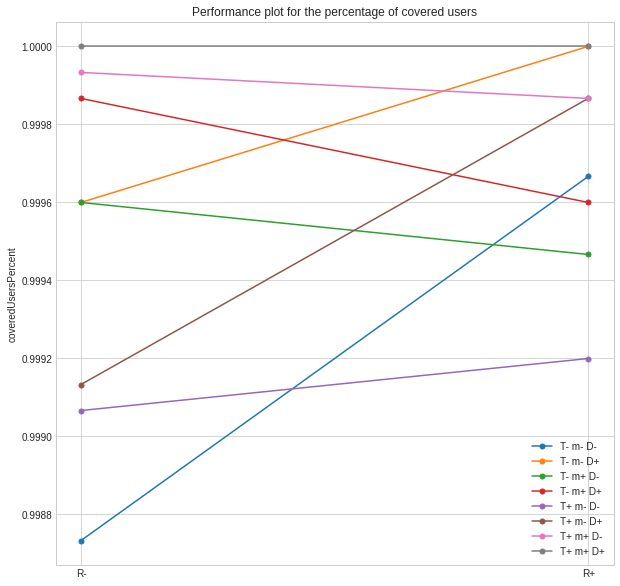

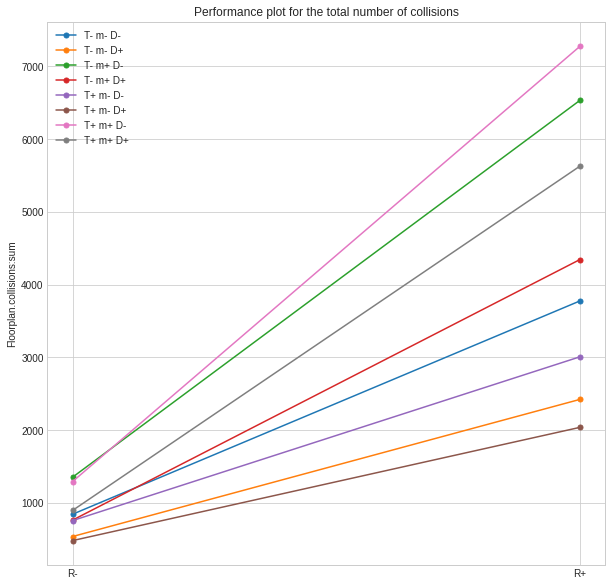

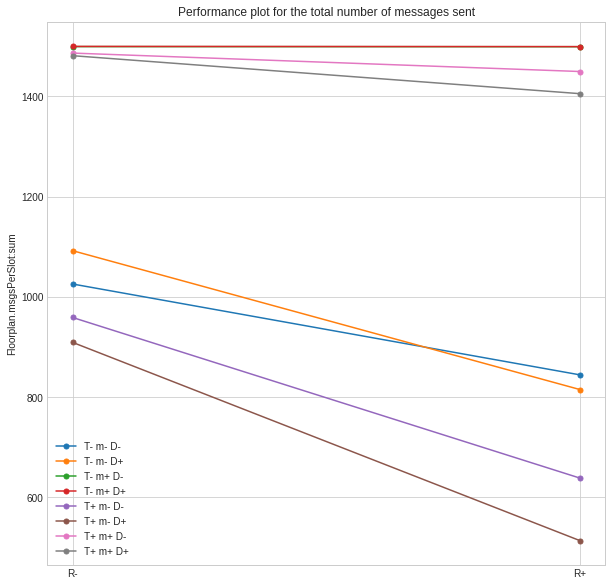

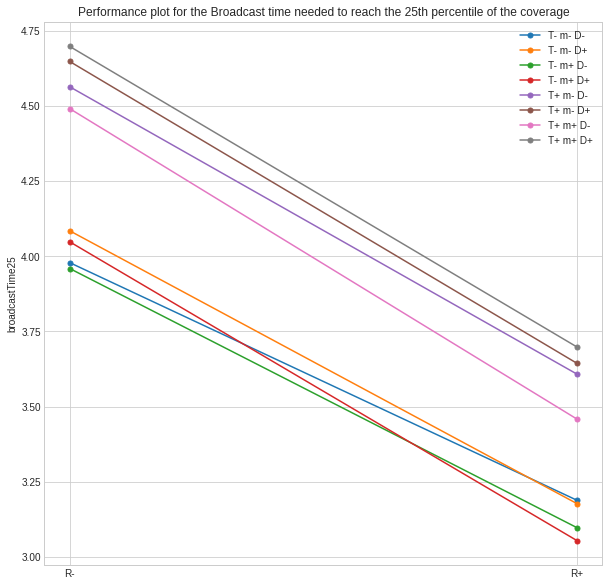

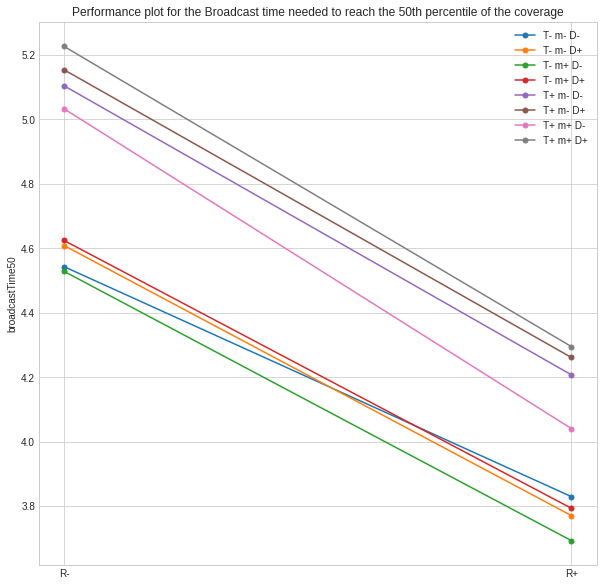

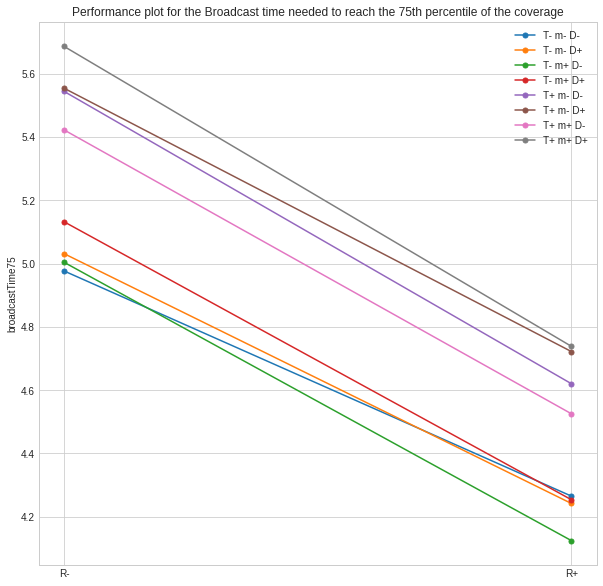

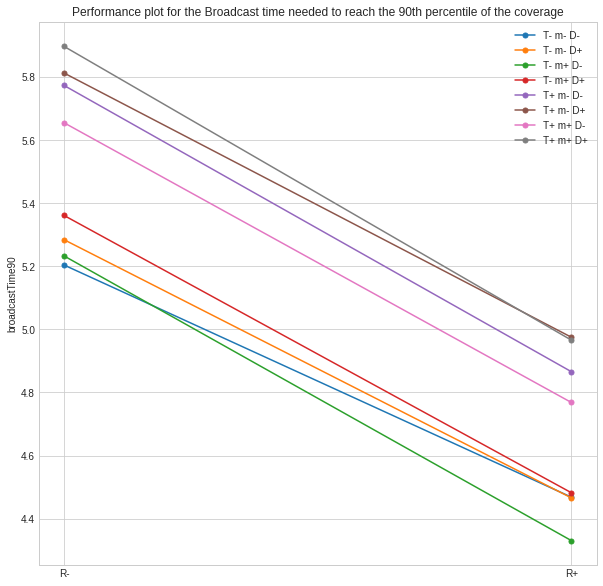

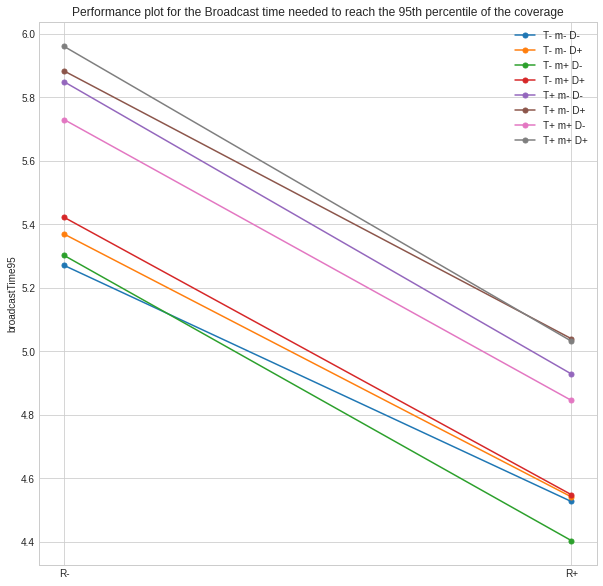

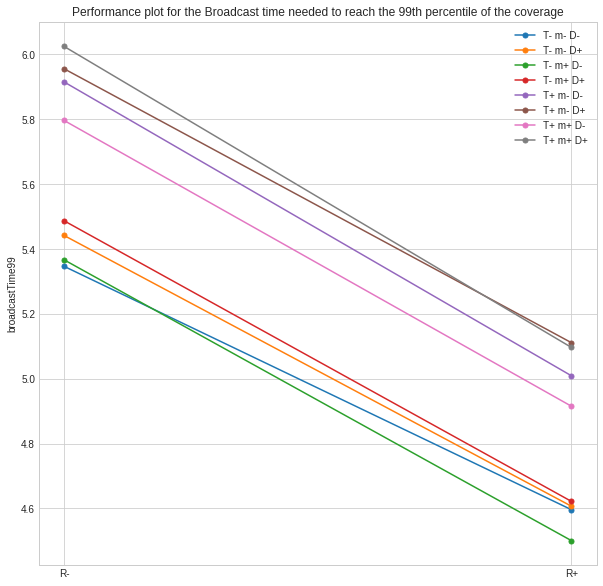

###########################

Plotting with T on the x axis...


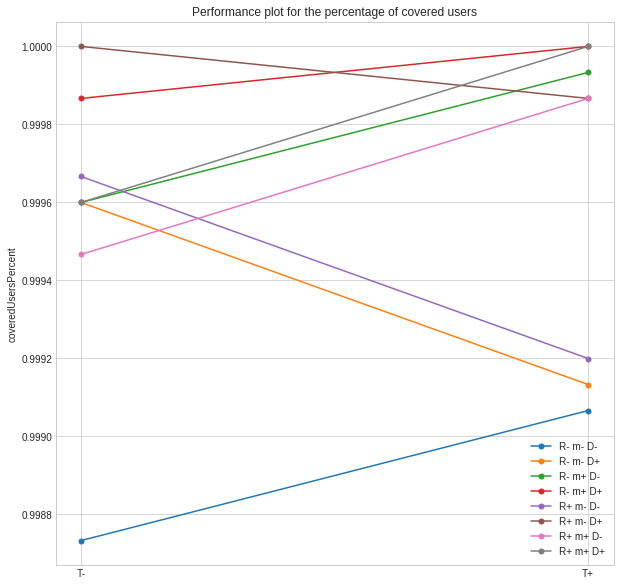

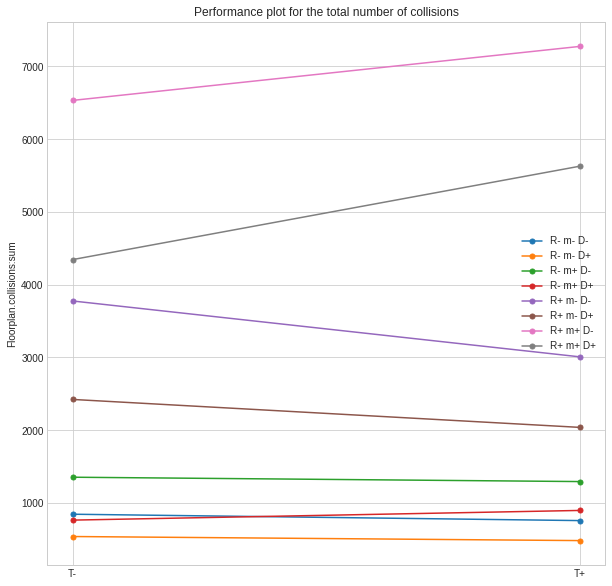

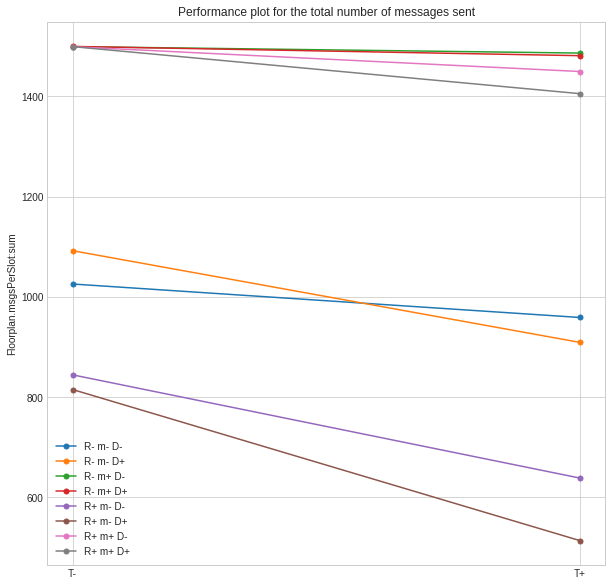

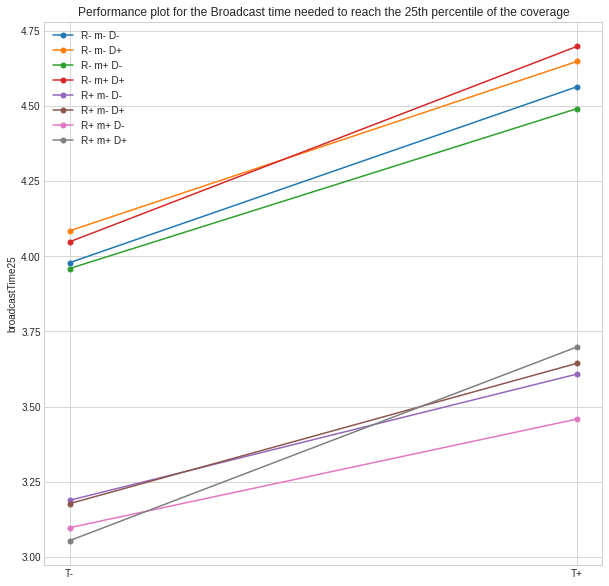

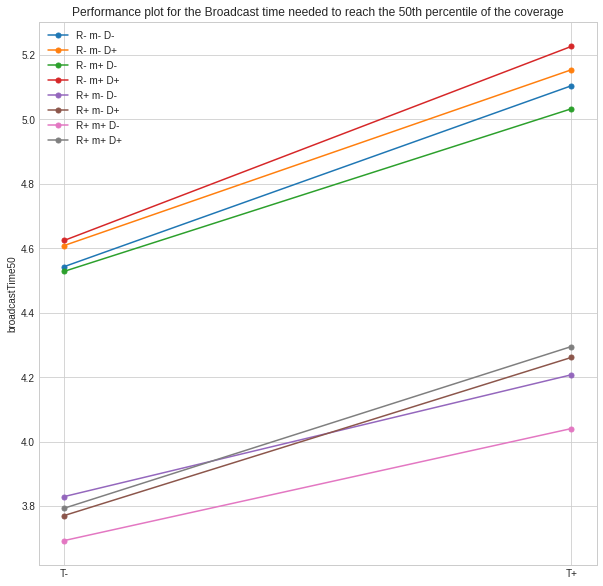

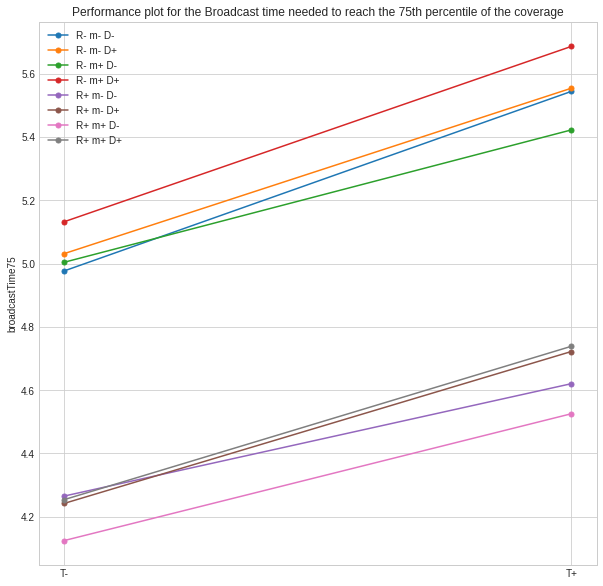

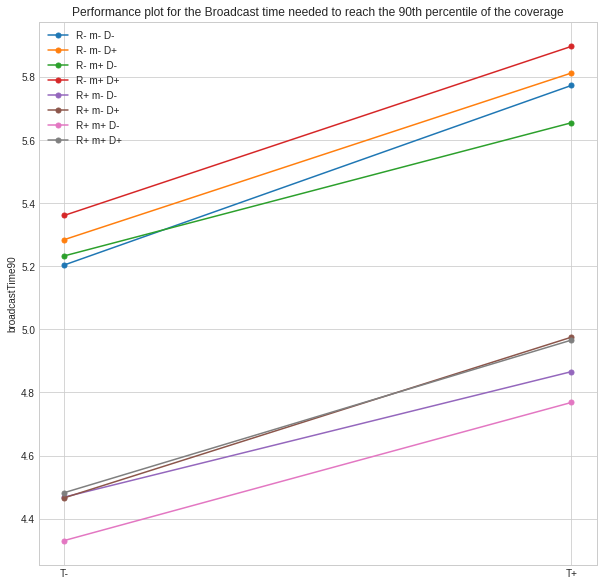

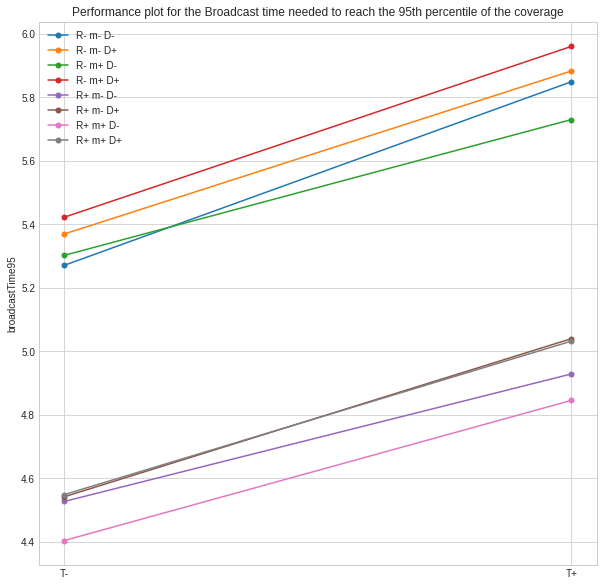

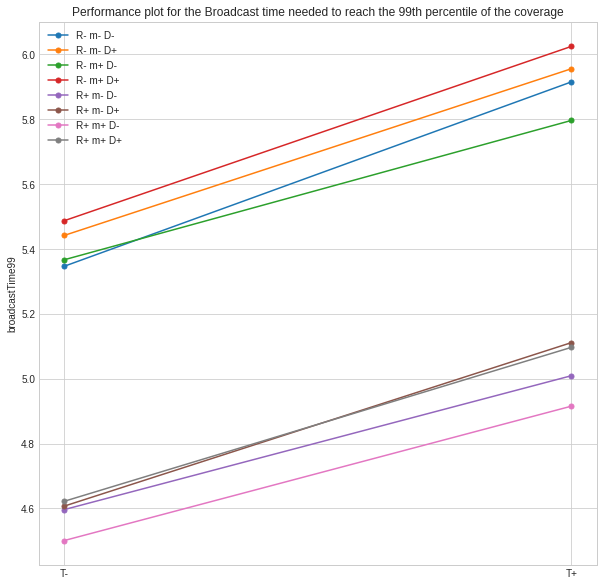

###########################

Plotting with m on the x axis...


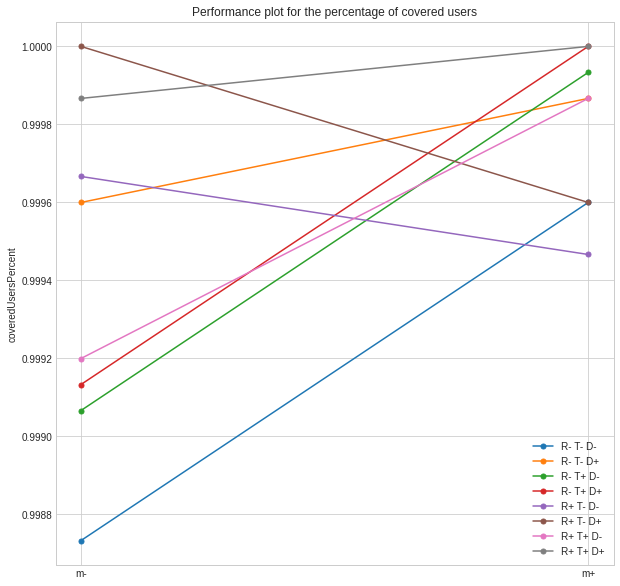

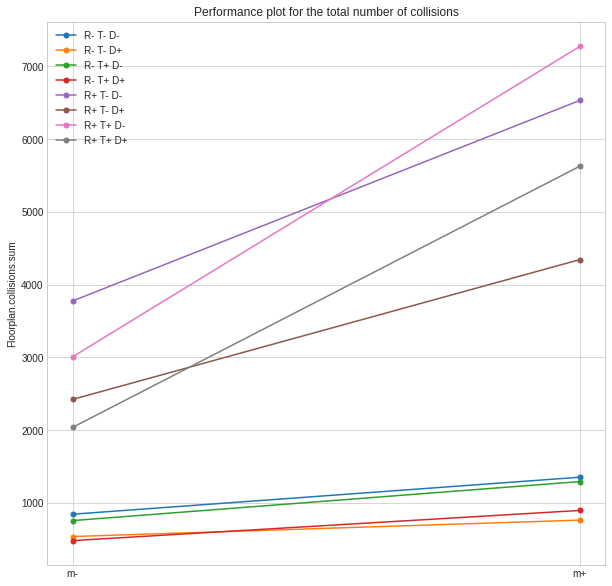

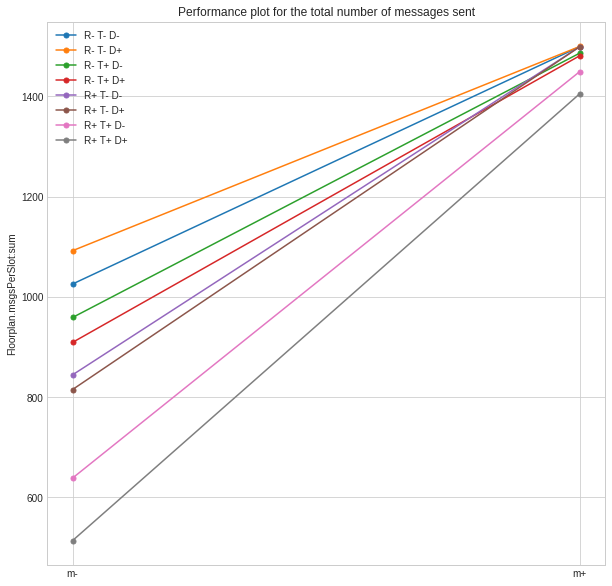

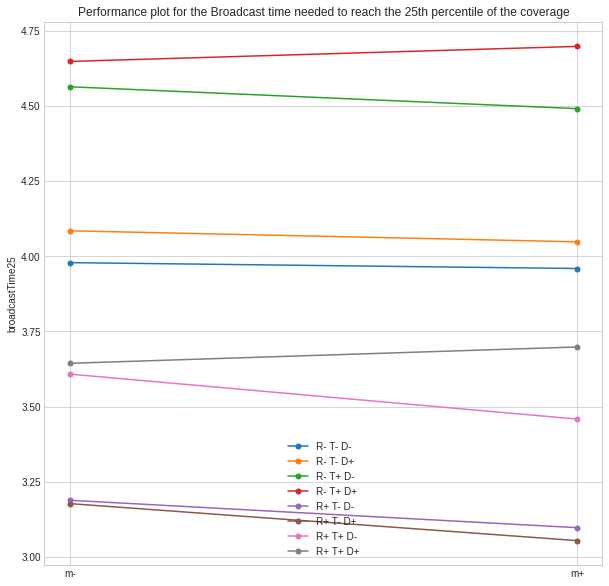

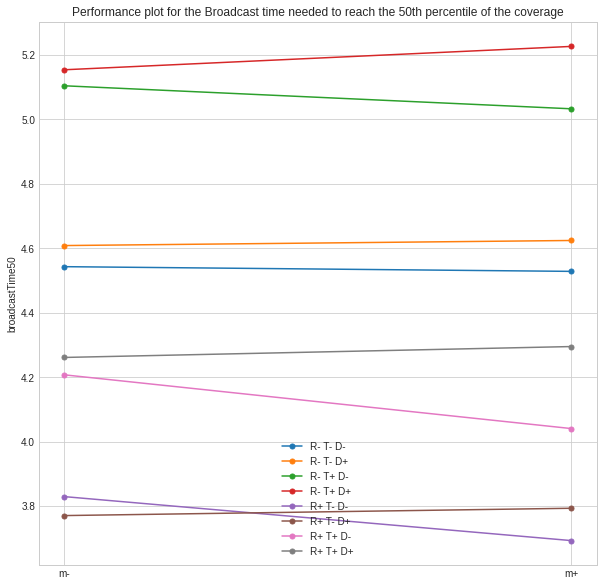

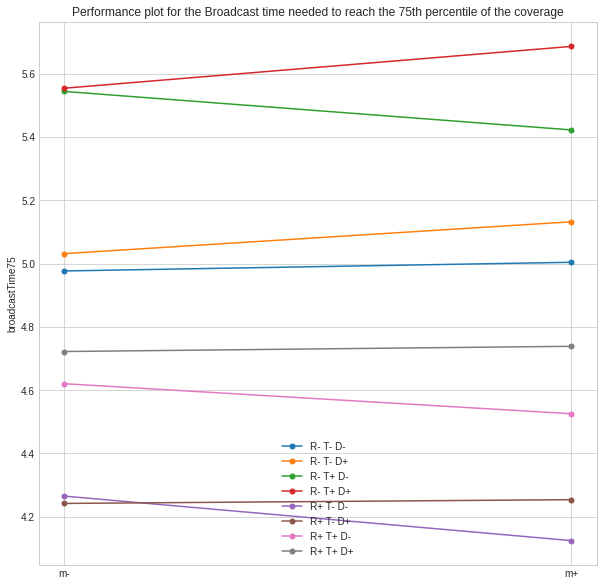

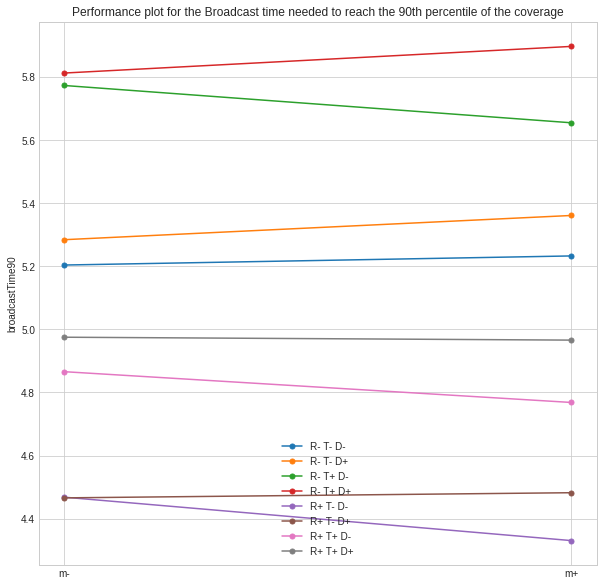

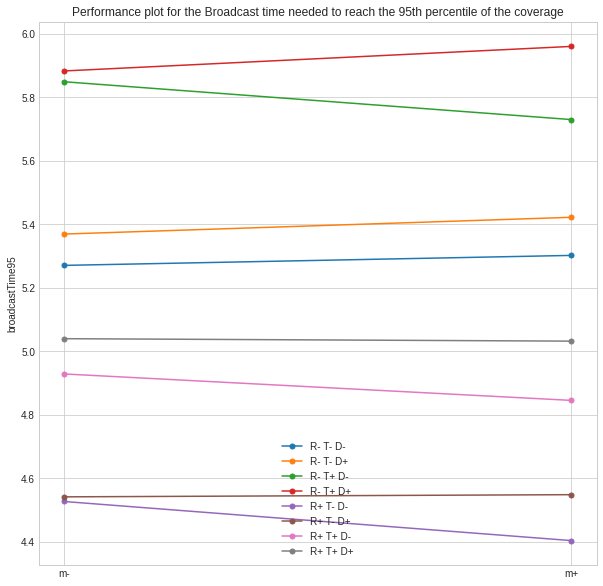

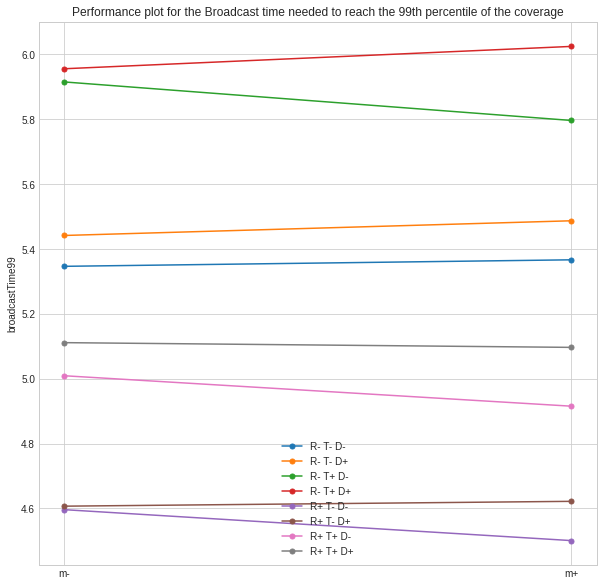

###########################

Plotting with D on the x axis...


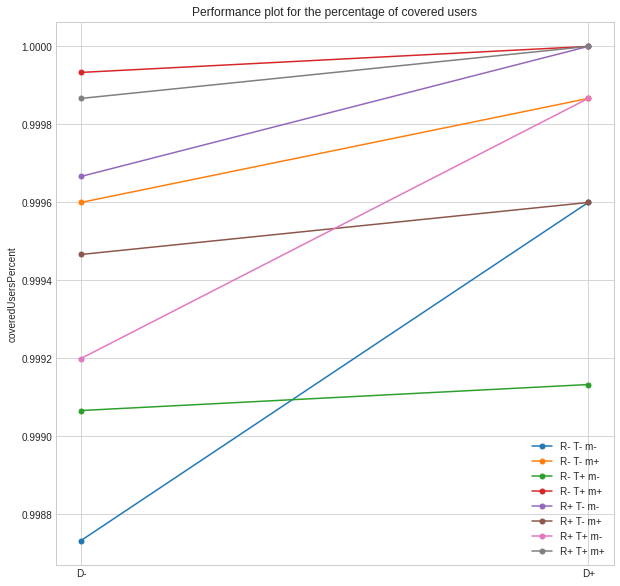

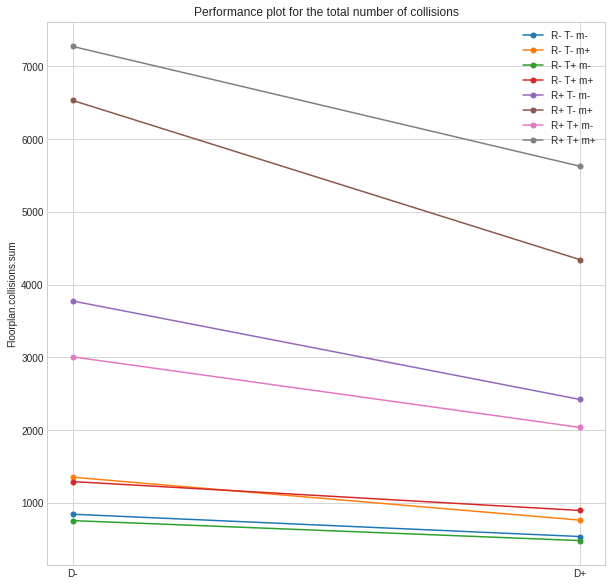

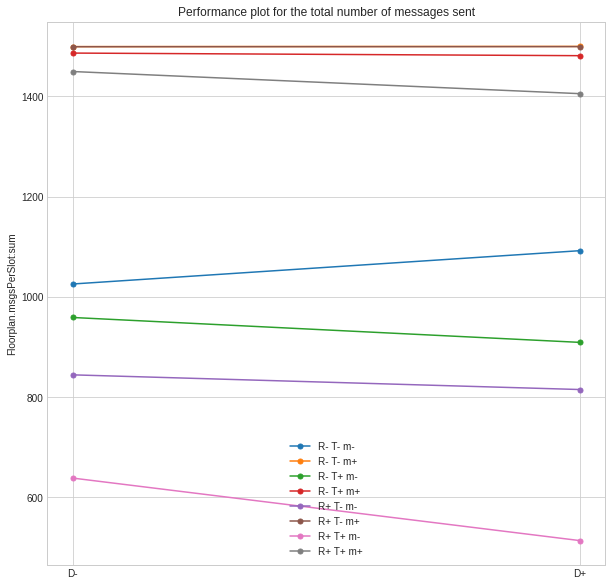

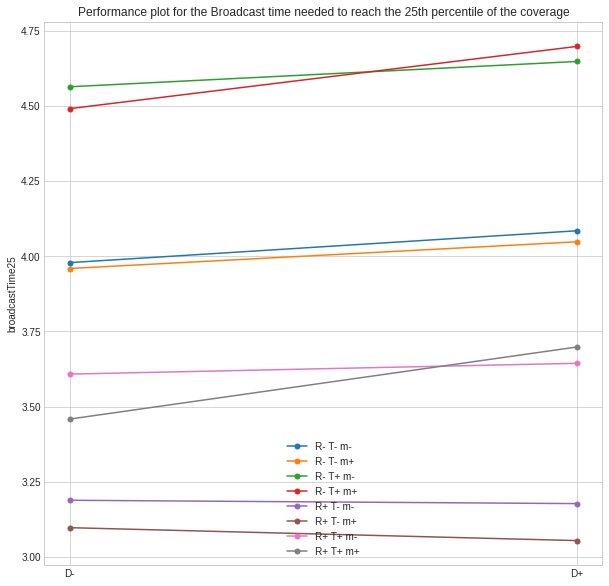

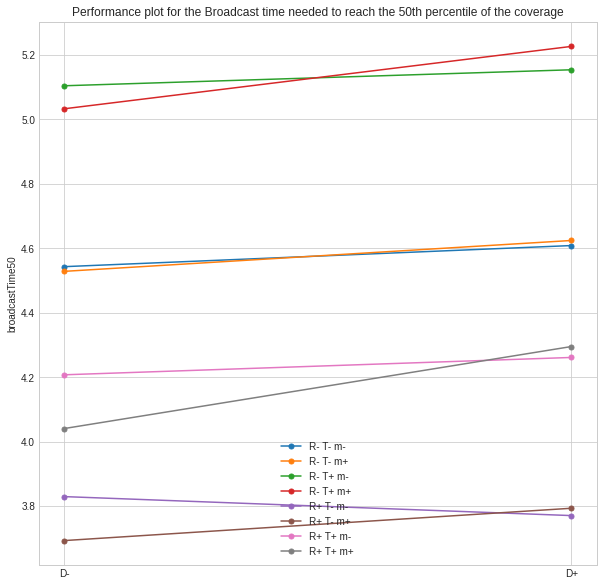

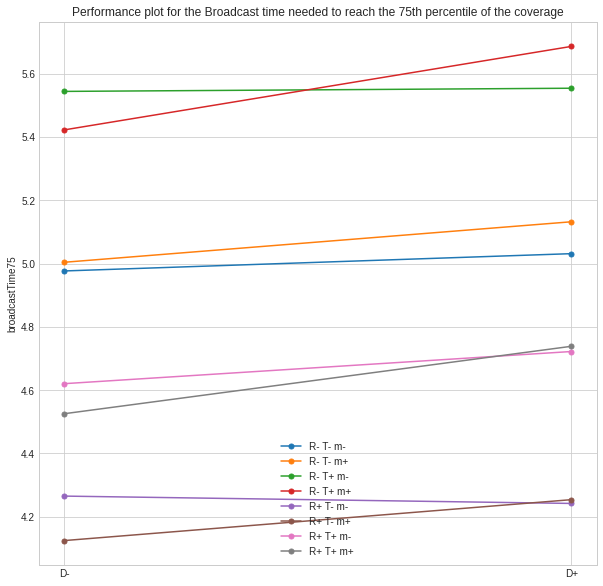

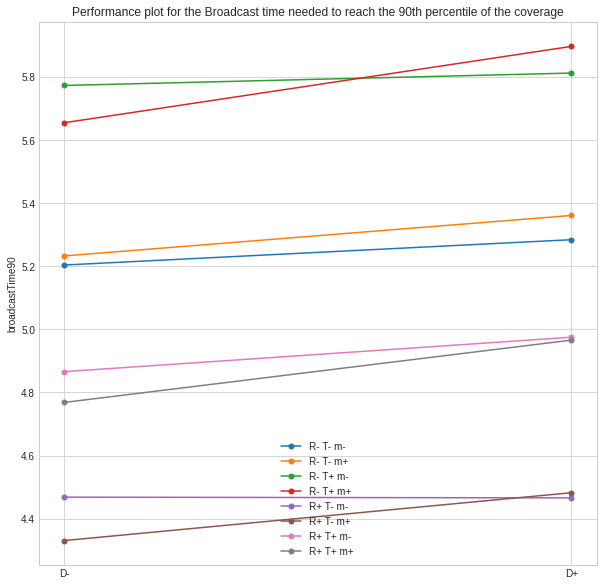

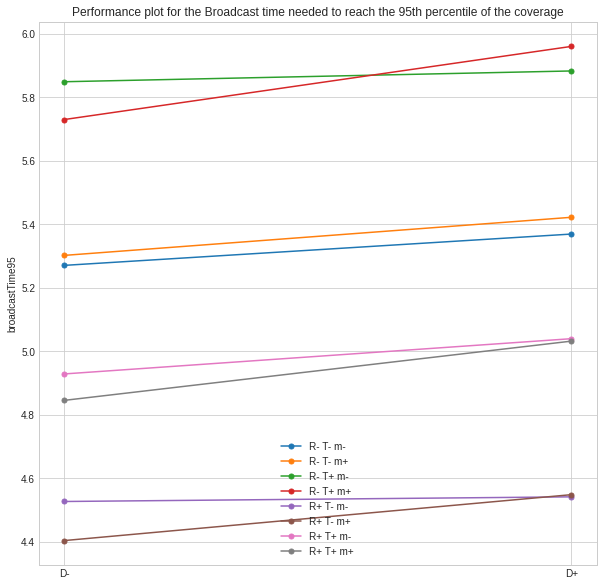

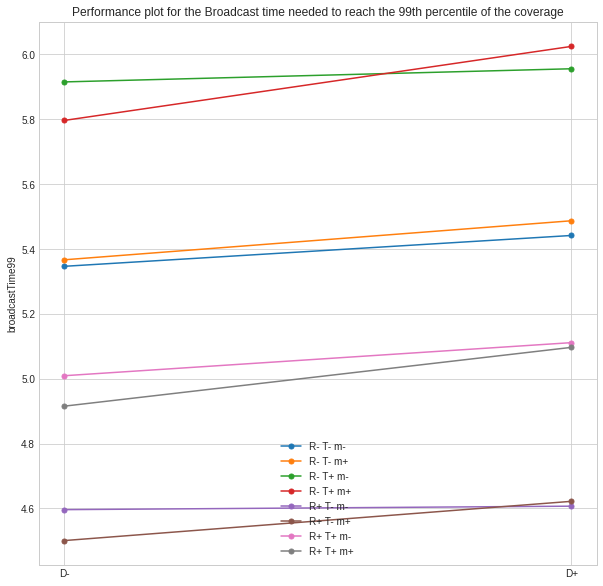

###########################



In [10]:
for xFactor in factors:
    print('Plotting with', xFactor, 'on the x axis...')
    xarr = np.array([-1, 1])
    idx = 0
    factorsMatrix.sort_values([xFactor] + [fac for fac in factors if fac != xFactor], inplace=True)
    for perfIndex, perfIndexDesc in perfIndexes:
        if perfIndex in skipped:
            continue
        ys = []
        fs = []
        for _, row in factorsMatrix.iterrows():
            y = np.sum(row[['I'] + combinedFactors].values * computeMatrices[idx].loc['Mean (Qi)', ['I'] + combinedFactors].values)
            fs.append(' '.join([f + str('+' if row[f] == 1 else '-') for f in [fac for fac in factors if fac != xFactor]]))
            ys.append(y)

        plt.figure(figsize=plotSize)
        plt.style.use(plotStyle)
        plt.xticks(xarr, (xFactor + '-', xFactor + '+'))
        ys = [y for y in zip(ys[:configsCount//2], ys[configsCount//2:])]
        for y, lbl in zip(ys, fs):
            yarr = np.array(y)
            plt.plot(xarr, yarr, linestyle='-', marker='.', markersize=10, label=lbl)
        plt.title('Performance plot for the ' + perfIndexDesc)
        plt.ylabel(perfIndex)
        plt.legend()
        if saveFigures:
            fig = plt.gcf()
            fig.savefig('figures/' + get_file_name(perfIndex) + '-' + xFactor + '-perfplot.png')
        plt.show()
        idx += 1
    print('###########################')
    print()